EGR 557 Foldable Robotics
System Kinematics
Team 7

In [2]:
# RUN PIP INSTALL CODE BLOCK

# Install standard packages...
!pip install meshio pygmsh ezdxf pandoc-fignos pandoc-eqnos pypdf4 service_identity ftd2xx pygithub twine paho-mqtt
!pip install ntplib pygame pysftp pyserial

# Install foldable-robotics-specific packages.
!pip install pypoly2tri idealab_tools foldable_robotics pynamics

/bin/sh: pip: command not found
/bin/sh: pip: command not found
/bin/sh: pip: command not found


**3. **Using a pynamics-based script, develop a kinematic model for your device. Following the triple pendulum example,

1. Import packages
2. Define variables and constants (you may want to add, remove, or rename variables to match your figure)
3. Declare frames (you may need to add frames or rename them)
4. Define frame rotations (you may want to switch the axis about which frames rotate)
5. Compose kinematics (this depends entirely on the geometry of your system)
6. Take time-derivatives of position vectors
7. Assemble into a Jacobian that maps input velocities to output velocities.

In [10]:
#%% Develope a kinematic model

# import pachages
import pynamics
from pynamics.frame import Frame
from pynamics.variable_types import Differentiable,Constant
from pynamics.system import System
#from pynamics.body import Body
#from pynamics.dyadic import Dyadic
from pynamics.output import Output,PointsOutput
#from pynamics.particle import Particle
import pynamics.integration
import sympy
import numpy
import matplotlib.pyplot as plt
plt.ion()
from math import pi
#from pynamics.constraint import Constraint
import scipy.optimize


# Create Pynamic system
system = System()
pynamics.set_system(__name__,system)


# Define constants and vaiables
lA = Constant(6,'lA',system)
lB = Constant(18,'lB',system)
lC = Constant(6,'lC',system)
lD = Constant(3,'lD',system)


qA,qA_d,qA_dd = Differentiable('qA',system)
qB,qB_d,qB_dd = Differentiable('qB',system)
qC,qC_d,qC_dd = Differentiable('qC',system)


initialvalues = {}
initialvalues[qA]=-90*pi/180
initialvalues[qA_d]=0*pi/180
initialvalues[qB]=90*pi/180
initialvalues[qB_d]=0*pi/180
initialvalues[qC]=90*pi/180
initialvalues[qC_d]=0*pi/180


statevariables = system.get_state_variables()


# Define frames and frames rotations
N = Frame('N')
A = Frame('A')
B = Frame('B')
C = Frame('C')


system.set_newtonian(N)

A.rotate_fixed_axis_directed(N,[0,0,1],qA,system)
B.rotate_fixed_axis_directed(A,[0,0,1],qB,system)
C.rotate_fixed_axis_directed(B,[0,0,1],qC,system)


# Define kinematics

pNA = 0*N.x + 0*N.y
pAB = pNA + lA*A.x
pBC = pAB + lB*B.x
pBmid = pAB + lD*B.x
pCtip = pBmid + lC*C.x
pD = lD*N.x

points = [pNA,pAB,pBC,pBmid,pCtip]


# Take time derivatives of position vectors
vNA = pNA.time_derivative()
vAB = pAB.time_derivative()
vBC = pBC.time_derivative()
vBmid = pBmid.time_derivative()
vCtip = pCtip.time_derivative()
vD = pD.time_derivative()


# Form Jacobian
# The relaionship of input velocity and output velocity of this device is: vBC = J*qA_d


statevariables = system.get_state_variables()
ini0 = [initialvalues[item] for item in statevariables]

# Define constraints
eq_vector = pCtip-pD

eq = []
eq.append((eq_vector).dot(N.x))
eq.append((eq_vector).dot(N.y))
eq_d=[(system.derivative(item)) for item in eq]

**4. **Select or Solve for a valid initial condition that represents the system in the middle of a typical gait, when it is both moving and when forces are being applied to it (or to the world by it)

Despite the fact that you will be using a symbolic representation, you still need to solve for a valid initial condition if your device is a “parallel mechanism.” This may be done using a nonlinear solver such as scipy.optimize.minimize

In [11]:
#%% Solve for initial condition
qi = [qA]
qd = [qB,qC]

constants = system.constant_values.copy()
defined = dict([(item,initialvalues[item]) for item in qi])
constants.update(defined)

eq = [item.subs(constants) for item in eq]


error = (numpy.array(eq)**2).sum()


f = sympy.lambdify(qd,error)

def function(args):
    return f(*args)


#Take the derivative of the equations to linearize with regard to the velocity variables
guess = [initialvalues[item] for item in qd]


result = scipy.optimize.minimize(function,guess)
if result.fun>1e-3:
    raise(Exception("out of tolerance"))
    
    
ini = []
for item in system.get_state_variables():
    if item in qd:
        ini.append(result.x[qd.index(item)])
    else:
        ini.append(initialvalues[item])
        
        
# Find Jacobian
eq_d = sympy.Matrix(eq_d)

qi = sympy.Matrix([qA_d])
qd = sympy.Matrix([qB_d,qC_d])

AA = eq_d.jacobian(qi)
BB = eq_d.jacobian(qd)

J = -BB.inv()*AA
J.simplify()

# Solve for dependent variables
qd2 = J*qi


subs = dict([(ii,jj) for ii,jj in zip(qd,qd2)])

pout = pBC
vout = pout.time_derivative()
vout = vout.subs(subs)

**5.** Plot the system in this position.

2021-02-19 18:44:15,612 - pynamics.output - INFO - calculating outputs
2021-02-19 18:44:15,613 - pynamics.output - INFO - done calculating outputs


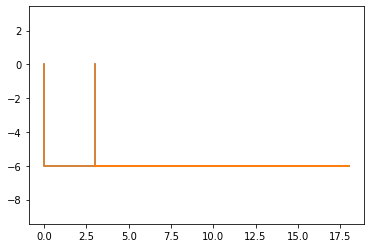

In [12]:
# Plot the system
        
points = PointsOutput(points, constant_values=system.constant_values)
points.calc(numpy.array([ini0,ini]))
points.plot_time()

6. From your biomechanics-based specifications, define one or more force vector estimates (one for each end effector) that the system should be expected to experience.

In [13]:
# Define force at end-effector

# From out biomechanics background research, the maximum force needed to push the jaw during the motion is 0.22 N.
# Scale the size, our maximum force experienced by the end-effector will be around 0.5 N. (From acceleration)
F_a_max = sympy.Matrix([0.5,0])

# There's no ground reaction force during the motion



7. Calculate the force or torque required at the input to satisfy the end-effector force requirements

In [14]:
t_max = J.T*F_a_max
t_max

⎡     ⎛lA⋅sin(qB)                  ⎞ ⎤
⎢-0.5⋅⎜────────── + lA⋅cos(qB) + lD⎟ ⎥
⎢     ⎝ tan(qC)                    ⎠ ⎥
⎢────────────────────────────────────⎥
⎣                 lD                 ⎦

8. Estimate the velocity of the end-effector in this configuration. Using the Jacobian, calculate the speed required by the input(s) to achieve that output motion.

In [15]:
# From our biomechanics studying, the mean max speed is 2.31 m/s
v_max = sympy.Matrix([2.31,0])
qA_d_max = J.T*v_max
qA_d_max

⎡      ⎛lA⋅sin(qB)                  ⎞ ⎤
⎢-2.31⋅⎜────────── + lA⋅cos(qB) + lD⎟ ⎥
⎢      ⎝ tan(qC)                    ⎠ ⎥
⎢─────────────────────────────────────⎥
⎣                  lD                 ⎦

9. Finally, using the two estimates about force and speed at the input, compute the required power in this configuration.

In [16]:
P_max = t_max*qA_d_max.T
P_max

⎡                                    2⎤
⎢      ⎛lA⋅sin(qB)                  ⎞ ⎥
⎢1.155⋅⎜────────── + lA⋅cos(qB) + lD⎟ ⎥
⎢      ⎝ tan(qC)                    ⎠ ⎥
⎢─────────────────────────────────────⎥
⎢                   2                 ⎥
⎣                 lD                  ⎦

**Discussion**

Answer the following questions

1. How many degrees of freedom does your device have? How many motors? If the answer is not the same, what determines the state of the remaining degrees of freedom? How did you arrive at that number?

The device has one degree of freedom as of now. So only one motor as of now. But the degrees of freedom will change after we design the end effector for the system. So more motors may be required. Once the end effector is designed, the team's website will be updated with the total degrees of freedom for the system and the total number of motor that will be finally used.



2. If your mechanism has more than one degree of freedom, please describe how those multiple degrees of freedom will work togehter to create a locomotory gait or useful motion. What is your plan for synchonizing, especially if passive energy storage?

The mechanism currenlty has only one degree of freedom. The descripion about how the system will work together to create a locomotory gait or useful motion will be added to the team's website after the end effector is designed and more degrees of freedom are added to the system later. The plan for synchronizing will also be updated on the team's website after the end effector is designed.



3. How did you estimate your expected end-effector forces ? 

From our biomechanics studying, what we know is the maximum acceleration during the motion, we assume acceleration profiles are sinusoidal. Therefore, maximum acceleration happens at t = 0, goes to 0 at the midpoint and becomes negative from midpoint to reaching the prey.
We also know the mass of the device; therefore, we can compute the force profile required for our device by using F = m*a.



4. How did you estimate your expected end-effector speeds ?

From literatures, we found the maximum speed and we know the speed at the initial point and final point is 0. Then, we just assume the speed profile is a sinusoildal function and fit the known parameters into the function.